In [1]:
import math

import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import matplotlib.pyplot as plt
import seaborn as sns

import petab
import numpy as np
from scipy.special import gammaln
from scipy.special import gamma
import pickle
from copy import deepcopy
import pandas as pd

In [2]:
datatype = "loss"

# Load experimental data
if datatype == "original":
    df=pd.read_csv('data/data.csv', sep='\t')
elif datatype == "switch":
    df=pd.read_csv('data/data_switch.csv', sep='\t')
else:
    df=pd.read_csv('data/data_loss.csv', sep='\t')
    
add_offset_to_data = True
offset_value = 0.2

if add_offset_to_data:
    df.Measurement=df.Measurement+offset_value
    
data = np.asarray(df.Measurement)

tvec = np.asarray(df.Time)
    
N = len(tvec)

In [3]:
def analytical_x2(t, t0, kTL_m0, xi, delta):
    X = [np.exp(-delta*(t-t0)) * (t>t0),
         kTL_m0 * (np.exp(-xi*(t-t0)) - np.exp(-delta*(t-t0))) / (delta-xi) * (t>t0)]
    return X[1]

def simulate_model(x, tvec):
    # assign parameters
    t0, kTL_m0, xi, delta, _ = x
    # simulate model
    simulation = np.asarray([analytical_x2(t, t0, kTL_m0, xi, delta)
                             for t in tvec])
    return simulation

After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

\begin{align*}
    \log(p(D \mid \theta, \sigma)) =& \log(\lambda) - N \cdot ( log(\sigma) + \log(2)) + \log \left( \sum_{i = r}^N k_i \right)
\end{align*}

Hereby $k_i$ is defined differently depending on the value of $\frac{N - 2i}{\sigma} - \lambda$. We have
 \begin{align*}
     k_r \equiv
     \begin{cases}
         \displaystyle \frac{\sigma}{N -2r - \sigma\lambda} \cdot \left(\exp \left( \frac{b_{r + 1}(N - 2r) + l_r}{\sigma} - b_{r + 1}\lambda \right) - \exp \left( \frac{l_r}{\sigma} \right) \right), &\text{if} \; \frac{N - 2r}{\sigma} - \lambda \neq 0 \\
         \displaystyle b_{r + 1} \exp \left( \frac{l_r}{\sigma} \right), &\text{if} \; \frac{N - 2r}{\sigma} - \lambda = 0
     \end{cases}
 \end{align*}
 and for $i = r + 1, \ldots, N -1$
 \begin{align*}
     k_i \equiv
     \begin{cases}
         \frac{\sigma}{N -2i - \sigma\lambda} \cdot \left(\exp \left( \frac{b_{i + 1}(N - 2i) + l_i}{\sigma} - b_{i + 1}\lambda \right) - \exp\left( \frac{b_{i}(N - 2i) + l_i}{\sigma} - b_{i}\lambda \right) \right), &\text{if} \; \frac{N - 2i}{\sigma} - \lambda \neq 0 \\
         \displaystyle \left(b_{i + 1} - b_i \right) \exp \left( \frac{l_i}{\sigma} \right), &\text{if} \; \frac{N - 2i}{\sigma} - \lambda = 0
     \end{cases}
 \end{align*}
 and because $-N / \sigma - \lambda < 0$ we have always
 \begin{align*}
     k_N \equiv \frac{1}{N + \sigma\lambda} \cdot \exp \biggl(\frac{-b_N N + l_N}{\sigma} - b_N \lambda \biggr).
 \end{align*}

In [4]:
def negative_log_marginalised_likelihood(x):
    shape = x[4]
    
    # simulate model
    _simulation = simulate_model(np.power(10, x), tvec)
    simulation = np.asarray(_simulation)
    
    # evaluate standard log likelihood
    #We sort the difference of data and simulation in increasing order
    res = data - simulation
    b_vector = np.sort(res)
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    #r is the greatest index such that bounds[r] < 0
    #especially r in the code has the same value as r in the derivation
    r = np.argmax(bounds >= 0)-1
    
    
    
    #special case i = r
    check = (N - 2*r)/shape - lamda
    #index choice because we use b_vector not bounds
    l_value = np.sum(b_vector[:r]) - np.sum(b_vector[r:])
    tmp = l_value/shape
    if check != 0:
        aux1 = 1 / check
        aux2 = (np.exp(tmp + bounds[r+1]*check)-np.exp(tmp))
    else:
        aux1 = bounds[r + 1]
        aux2 = np.exp(tmp)
    
    marginal_posterior = aux1 * aux2
    
    #general case i = r+1, ..., N-1
    for n in range(r + 1, N):
        #It is sufficient to add the change
        l_value += 2 * bounds[n]
        tmp = l_value / shape
        check = (N - 2*n)/shape - lamda
        
        if check != 0:
            aux1 = 1 / check
            aux2 = np.exp(tmp + bounds[n+1]*check) - np.exp(tmp + bounds[n]*check)
        else:
            aux1 = bounds[n + 1]
            aux2 = np.exp(tmp)
        
        
        #here we add up the k_i values
        marginal_posterior += aux1*aux2
        
        
    #special case i = N
    l_value += 2 * bounds[N]
    tmp = l_value / shape
    aux1 = 1/(N + shape*lamda)
    aux2 = np.exp(tmp - bounds[N]*(N/shape + lamda))
    
    marginal_posterior += aux1 * aux2
        
        
        
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += -N*(np.log(2) + np.log(shape)) + np.log(lamda)
    
    return -log_marginal_posterior

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [5]:
def marginal_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_marginalised_likelihood)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-2, -5, -5, -5, np.exp(-5)],  # lower bounds
                              ub=[np.log10(df.Time.max()), 5, 5, 5, np.exp(5)],  # upper bounds
                              x_names=['t_0', 'k_{TL}*m_0', 'xi', 'delta', 'shape'],  # parameter names
                              x_scales=['log10', 'log10', 'log10', 'log10', 'lin'])  # parameter scale
    return problem

In [6]:
### Prior dependent paramters
lamda = 0.01

# create the estimation problem
problem = marginal_sampling()

# MCMC chain length
n_samples= 1000000

In [7]:
x0 = [np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2])]

cov0 = 1e-4

# call the sampler of choice
sampler = sample.AdaptiveParallelTemperingSampler(n_chains=10, internal_sampler=
                                                  sample.AdaptiveMetropolisSampler(options={'cov0': cov0}))

Now we can perform the actual sampling.

In [8]:
# Define number of runs
runs = 1

save_results = False # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler,
                           x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        results = [result.sample_result]
        with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
            pickle.dump(results, result_file, n)

100%|██████████| 1000000/1000000 [2:31:47<00:00, 109.80it/s] 
Elapsed time: 8763.715799
Geweke burn-in index: 0
Estimated chain autocorrelation: 1536.6185431274553
Estimated effective sample size: 650.357011151828


There are some built-in visualization functions that one can use.

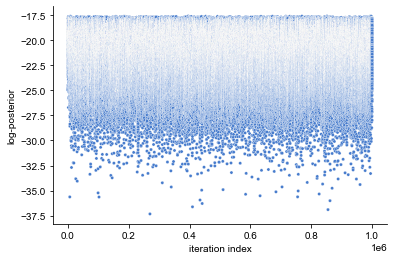

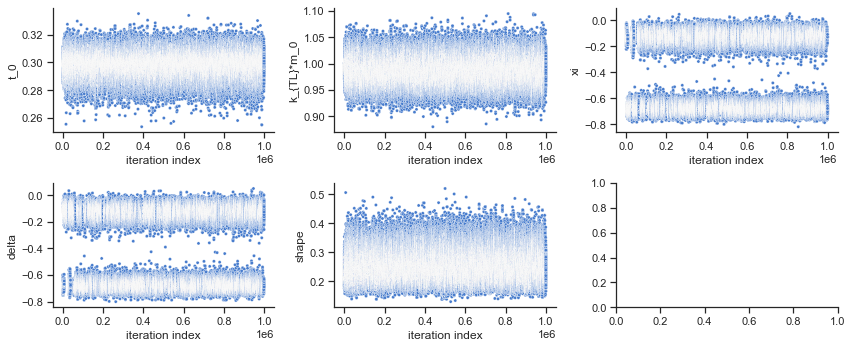

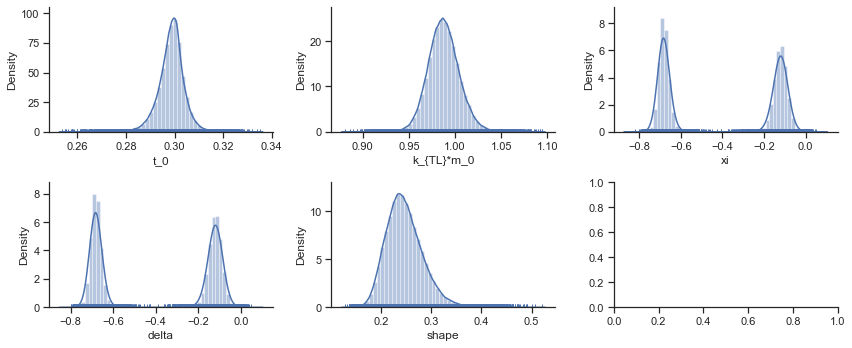

In [9]:
ax = visualize.sampling.sampling_fval_traces(result,full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling.sampling_parameters_trace(result, use_problem_bounds=False,
                                                  full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals
ax = visualize.sampling_1d_marginals(result, size=(12,5))

Now we want to sample the offset $c$ from our generated data. It is distributed as a piecewise exponential distribution with this density function:

\begin{align*}
    \mathbf{1}_{[0, b_{r + 1})}(c) \exp\biggl( c \cdot \biggl( \frac{N - 2r}{\sigma} - \lambda \biggr) + \frac{l_r}{\sigma} \biggr) + \sum_{i = r + 1}^N \mathbf{1}_{[b_i, b_{i + 1})}(c) \exp \biggl( c \cdot \biggl( \frac{N - 2i}{\sigma} - \lambda \biggr) + \frac{l_i}{\sigma} \biggr)
\end{align*}

To sample this distribution we also need the mass of the corresponding integral over every section:

\begin{align*}
I_r &=
\begin{cases}
         \displaystyle \frac{\sigma}{N -2r - \sigma\lambda} \cdot \left(\exp \left( \frac{b_{r + 1}(N - 2r) + l_r}{\sigma} - b_{r + 1}\lambda \right) - \exp \left( \frac{l_r}{\sigma} \right) \right), &\text{if} \; \frac{N - 2r}{\sigma} - \lambda \neq 0 \\
         \displaystyle b_{r + 1} \exp \left( \frac{l_r}{\sigma} \right), &\text{if} \; \frac{N - 2r}{\sigma} - \lambda = 0
\end{cases}\\
I_{i = r+1, \ldots, N-1} &= \begin{cases}
         \frac{\sigma}{N -2i - \sigma\lambda} \cdot \left(\exp \left( \frac{b_{i + 1}(N - 2i) + l_i}{\sigma} - b_{i + 1}\lambda \right) - \exp\left( \frac{b_{i}(N - 2i) + l_i}{\sigma} - b_{i}\lambda \right) \right), &\text{if} \; \frac{N - 2i}{\sigma} - \lambda \neq 0 \\
         \displaystyle \left(b_{i + 1} - b_i \right) \exp \left( \frac{l_i}{\sigma} \right), &\text{if} \; \frac{N - 2i}{\sigma} - \lambda = 0
     \end{cases} \\
I_N &= \frac{1}{N + \lambda\sigma} \cdot \exp \biggl(\frac{-b_N N + l_N}{\sigma} - b_N \lambda \biggr)
\end{align*}

As we have a piecewise defined probability distribution we use the weights of the corresponding integrals to choose with a uniformly distributed random variable $s$ in which part we are sampling. Afterwards we generate a random variable with the fitting shpae on that onterval

1. Sample uniformly distributed $s_1$ and determine smallest $i \in \{r, \ldots, N\}$ such that $s_1 \leq \frac{\sum_{k = r}^i I_k}{\sum_{l = r}^N I_l}$

2. We now want to sample the according random variable with support inside of $[b_i, b_{i + 1}]$ (with $b_r \equiv 0$).

3. We start by sampling a uniformly distributed random variable $s$ on $[0, 1]$. If $\frac{N - 2i}/\sigma - \lambda = 0$ we can just scale $s$ on $[b_i, b_{i + 1}]$. Else we can use the transformation 
\begin{align*}
        f(s) \equiv \frac{\log \left( \exp \left( \left(\frac{N - 2i}{\sigma} - \lambda \right) \cdot b_i \right) + s \cdot \left( \exp \left( \left(\frac{N - 2i}{\sigma} - \lambda \right) \cdot b_{i + 1} \right) - \exp \left( \left(\frac{N - 2i}{\sigma} - \lambda \right) \cdot b_i \right) \right) \right)}{\frac{N - 2i}{\sigma} - \lambda}
\end{align*}

In [10]:
def get_offset(data, simulation, shape, lamda):
    res = data - simulation
    b_vector = np.sort(res)
    
    N = len(data)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    r = np.argmax(bounds >= 0)-1
    
    probability_mass = np.zeros(N + 1 - r)
    
    #special case i = r
    check = (N - 2*r)/shape - lamda
    #index choice because we use b_vector not bounds
    l_value = np.sum(b_vector[:r]) - np.sum(b_vector[r:])
    tmp = l_value/shape
    if check != 0:
        aux1 = 1 / check
        aux2 = (np.exp(tmp + bounds[r+1]*check)-np.exp(tmp))
    else:
        aux1 = bounds[r + 1]
        aux2 = np.exp(tmp)
    
    probability_mass[0] = aux1 * aux2
    
    #general case i = r+1, ..., N-1
    for n in range(r + 1, N):
        #It is sufficient to add the change
        l_value += 2 * bounds[n]
        tmp = l_value / shape
        check = (N - 2*n)/shape - lamda
        
        if check != 0:
            aux1 = 1 / check
            aux2 = np.exp(tmp + bounds[n+1]*check) - np.exp(tmp + bounds[n]*check)
        else:
            aux1 = bounds[n + 1]
            aux2 = np.exp(tmp)
        
        
        #here we add up the k_i values
        probability_mass[n - r] = probability_mass[n - r - 1] + aux1*aux2
        
        
    #special case i = N
    l_value += 2 * bounds[N]
    tmp = l_value / shape
    aux1 = 1/(N + shape*lamda)
    aux2 = np.exp(tmp - bounds[N]*(N/shape + lamda))
    
    normalisation_constant = probability_mass[N - r -1] + aux1*aux2
    
    probability_mass = probability_mass / normalisation_constant
    probability_mass[N-r] = 1
    
    
    
    
    s = Generator.uniform(size = 2)
    i = np.argmax(probability_mass >= s[0])

    factor = (N - 2*(i + r))/shape - lamda
    if factor == 0:
        if i == 0:
            offset = s[1] * bounds[r + 1]
        else:
            offset = s[1] * (bounds[i + 1 + r] - bounds[i + r])
    else:
        if i == 0:
            lb = 0
        else:
            lb = bounds[i + r]

        if i == N - r:
            offset = np.log(1 - s[1])/ factor + lb
        else:
            ub = bounds[i + 1 + r]
            compensate = factor * ub
            offset = (compensate + np.log(np.exp(factor*lb - compensate) + s[1] *(np.exp(factor*ub - compensate) - np.exp(factor*lb - compensate)))) / factor
            
    return offset

In [11]:
Generator = np.random.default_rng()

offset_samples = np.zeros([np.shape(
    result.sample_result.trace_x[0, result.sample_result.burn_in:, 0])[0], 1])

for index, parameter_sample in enumerate(result.sample_result.trace_x[0, result.sample_result.burn_in:, :]):
    shape = parameter_sample[-1]
    _simulation = simulate_model(np.power(10, parameter_sample), tvec)
    simulation = np.asarray(_simulation)
    
    offset_samples[index, :] = get_offset(data, simulation, shape, lamda)
    
if save_results:
    results = [result.sample_result, offset_samples]
    with open('Results/Offset_marginalized/' + str(n) + '.pickle','wb') as result_file:
        pickle.dump(results, result_file, n)

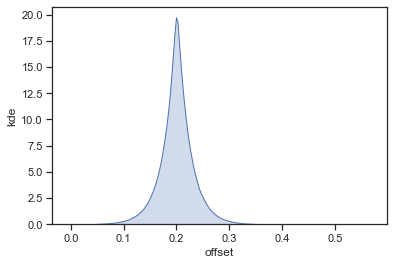

In [12]:
plt.figure()
ax = sns.kdeplot(offset_samples[:,0], shade=True, color='C0')
plt.xlabel('offset')
plt.ylabel('kde')
plt.show()

[ 0.29952487  0.98654778 -0.11989678 -0.68378461  0.22551739]
0.18410143552463307


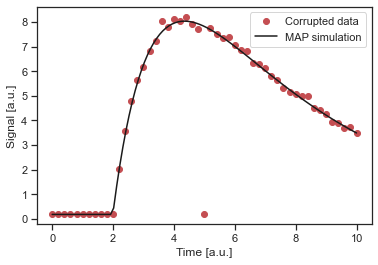

In [13]:
plot_MAP = True

if plot_MAP:
    MAP_index = np.argmax(-result.sample_result.trace_neglogpost[0,result.sample_result.burn_in:])
    MAP = result.sample_result.trace_x[0,result.sample_result.burn_in+MAP_index,:]
    print(MAP)

    tvec_for_plotting = np.linspace(tvec[0],tvec[-1],100)
    
    scale_MAP = MAP[-1]

    # simulate model
    _simulation = simulate_model(np.power(10, MAP), tvec)
    simulation = np.asarray(_simulation)
    
    offset_MAP = get_offset(data, simulation, scale_MAP, lamda)
    print(offset_MAP)
    
    _simulation = simulate_model(np.power(10, MAP), tvec_for_plotting)
    simulation_for_plotting = np.asarray(offset_MAP + _simulation)
    
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(tvec,data,'or',label='Corrupted data')
    plt.plot(tvec_for_plotting,simulation_for_plotting,'k',label='MAP simulation')
    plt.xlabel('Time [a.u.]')
    plt.ylabel('Signal [a.u.]')
    #plt.ylim([0,2])
    plt.legend()
    plt.show()